In [3]:
import numpy as np
import generate_lung_skeletons.skeleton_generation as sg
from generate_lung_skeletons.skeleton_generation import *
from generate_lung_skeletons.skeleton_generation import (
    add_rotation_to_tree, 
    augment_tree,
    augment_image,
    graph_to_image,
    graph_to_diluted_image,
    dilute_tree_image,
    add_noise_to_image_surface
)
from morphospaces.data.data_utils import (
    draw_line_segment,
    find_indices_within_radius,
)
from numpy.random import default_rng

from morphospaces.io.hdf5 import write_multi_dataset_hdf
from morphospaces.data.skeleton import compute_skeleton_vector_field,make_segmentation_distance_image, draw_proximal_vector_field, make_proximal_vector_image, make_skeleton_blur_image, make_point_blur, make_skeletonization_target
from generate_lung_skeletons import hdf5
import pickle
import networkx as nx
import skimage
from skeletolung.graph_cleanup import napari_plot_graph
import numpy.linalg as LA
from skimage.measure import label, regionprops
import  napari
import pickle
from typing import Tuple
from scipy.ndimage import distance_transform_edt
import pyclesperanto_prototype as cle
import raster_geometry as rg

from random import randint as rng

import h5py

import skeletolung
import sys
sys.path.insert(0, '/home/mmederacke/lung_fractal/simulation/code/updated/Lung_fractalisation')

# Now you can import the module
from simulation import Lung



In [4]:
#check results
with h5py.File('/home/mmederacke/lung_fractal/ml/synthetic_trainings_data/simulated_t/simulated_t3.h5','r') as f:
    label = f['label'][:]
    raw = f['raw'][:]
viewer = napari.Viewer()
viewer.add_image(raw)
viewer.add_labels(label)
viewer.add_labels(label ==2 )

napari.manifest -> 'skan' could not be imported: Could not find file 'napari.yaml' in module 'skan'
/home/mmederacke/anaconda3/envs/segmentation2/lib/python3.9/site-packages/morphometrics/measure/label.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
/home/mmederacke/anaconda3/envs/segmentation2/lib/python3.9/site-packages/superqt/qtcompat/__init__.py:7: UserWarning: The superqt.qtcompat module is deprecated as of v0.3.0. Please import from `qtpy` instead.


<Labels layer 'Labels' at 0x7fa6fd166d60>

In [77]:
def make_segmentation_distance_image_norm_non_vector(
    segmentation: np.ndarray,
) -> np.ndarray:
    """Make a distance image from a segmentation image.

    The distance image is normalized to the range with a local maximum filter[0, 1].

    Parameters
    ----------
    segmentation : np.ndarray
        The segmentation image.

    Returns
    -------
    np.ndarray
        The distance image.
    """
    distance_image, background_indices = distance_transform_edt(segmentation, return_distances=True, return_indices=True)

    max_distance = distance_image.max()  
    ball_radius = min(int(max_distance / 2), 8)

    distances_cle = cle.push(distance_image)
    local_maximum_cle = cle.maximum_sphere(
    distances_cle,
    radius_x=ball_radius,
    radius_y=ball_radius,
    radius_z=ball_radius
    )
    max_distance_image = np.asarray(local_maximum_cle)

    normalized_distance_image = np.zeros_like(distance_image)
    normalized_distance_image[segmentation] = distance_image[segmentation] / max_distance_image[segmentation]
    return normalized_distance_image


In [78]:
fp = skimage.morphology.ball(8)
fp = rg.ellipsoid(shape =fp.shape,semiaxes = (2,9,2), smoothing =False )
# viewer.add_image(fp)

In [79]:
def set_positions(graph:nx.Graph, step = None, inital_angle =90):
    """Derived from simulations "plot tree" function.

    Parameters
    ----------
 
    """
    # pos= hierarchy_pos(self.tree, root=0)
    g = graph.copy()


    pos = {}
    side = {}

    length = nx.get_edge_attributes(g, 'length')
    length = {edge:l*100_000  for edge, l  in length.items()}
   
    level = nx.get_edge_attributes(g, 'level')

    pos[1] = np.array([0,220])
    pos[0] = np.array([0,pos[1][1] + length[(0,1)]])
    for layer in nx.bfs_layers(g, 0):
        for node in layer:
            out_edges = list(g.out_edges(node)) 

            if len(out_edges) == 2:

                side[out_edges[0]] = 'left'
                side[out_edges[1]] = 'right'

                for s, edge in enumerate(out_edges):
                    if s ==0:
                        angle = np.radians(-inital_angle *1/(1+level[edge])**0.7)
                        y_change = np.cos(angle) * length[edge]
                        x_change = np.sin(angle) * length[edge] 

                        pos[edge[1]] = pos[node]+ np.array([-x_change,-y_change])
                    else:
                        angle = np.radians(inital_angle * 1/(1+level[edge])**0.7)
                        y_change = np.cos(angle) * length[edge]
                        x_change = np.sin(angle) * length[edge] 
                        pos[edge[1]] = pos[node]+ np.array([-x_change, -y_change])
    updated_postions = {}


    for node, position in pos.items():
        if node > 1:
            root = position
            subtree = g.subgraph(nx.dfs_tree(g, source = node).nodes())
            node_side = side[list(g.in_edges(node))[0]]
                
            rot_degree = np.radians(7 * max(level.values()))
            if step:
                rot_degree= np.radians(1* step)
            if node_side == 'left':
                rot_degree = rot_degree
            else:
                rot_degree = -rot_degree
            for sub_nodes in subtree.nodes:
                p = pos[sub_nodes]
                p = p - root
                
                R_matrix = np.matrix(([np.cos(rot_degree),-np.sin(rot_degree)],[np.sin(rot_degree),np.cos(rot_degree)]))
                p_rot = np.array(np.dot(R_matrix,p))
                p_rot = p_rot +  root
                updated_postions[sub_nodes] = p_rot.flatten()
            pos.update(updated_postions)

    updated_postions[0] = pos[0]
    updated_postions[1] = pos[1]
    print(updated_postions)

    nx.set_node_attributes(graph, updated_postions, 'pos')
    return graph,updated_postions

In [80]:
def graph_to_image(G:nx.Graph, pad_size =10):
    pos = np.asarray([n for n in dict(G.nodes(data = 'pos')).values()])
    update_level = {}
    for edge in G.edges():
        update_level[edge] = len(nx.shortest_path(G, 0, edge[0]))-1

    nx.set_edge_attributes(G, update_level, 'level')


    edges = np.array(list(G.edges(data = 'level')))



    x_offset = 0
    y_offset = 0
    z_offset = 0  
    x_coord = int(np.ceil(np.max(pos[:,0])  - x_offset))
    y_coord = int(np.ceil(np.max(pos[:,1]) - y_offset))
    z_coord = int(np.ceil(np.max(pos[:,2]) - z_offset))
    skeleton_image = np.pad(np.zeros((x_coord,y_coord,z_coord)), pad_width=pad_size)

    pos += pad_size

    #draw on imag
    skel_image =skeleton_image.copy()
    for i in range(edges.shape[0]):
        draw_line_segment(pos[edges[i]][0],pos[edges[i]][1],skel_image)

    return skel_image

<Axes: >

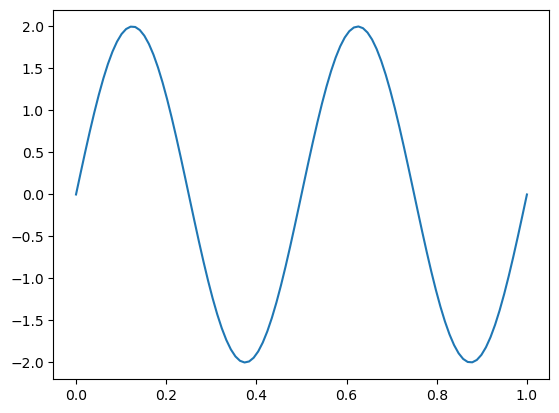

In [136]:
import seaborn as sns
time_points = np.linspace(0, 1, 100)
amplitude = 2
frequency = 2
sinusoidal_noise = amplitude * np.sin(2 * np.pi * frequency * time_points)
sinusoidal_noise

sns.lineplot(x = time_points, y = sinusoidal_noise)

In [221]:
np.repeat(1,10)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [220]:
np.random.uniform(-0.1, 0.1, size=10)

array([-0.09364444,  0.01716921, -0.0232705 ,  0.06919068,  0.00152866,
        0.06445825, -0.05533699, -0.04827083, -0.00218803,  0.08164704])

In [223]:
def draw_line_segment_wiggle(
    start_point: np.ndarray,
    end_point: np.ndarray,
    skeleton_image: np.ndarray,
    fill_value: int = 1,
    wiggle_factor: float = 0.1,
):
    """Draw a line segment in-place.

    Note: line will be clipped if it extends beyond the
    bounding box of the skeleton_image.

    Parameters
    ----------
    start_point : np.ndarray
        (d,) array containing the starting point of the line segment.
        Must be an integer index.
    end_point : np.ndarray
        (d,) array containing the end point of the line segment.
        Most be an integer index
    skeleton_image : np.ndarray
        The image in which to draw the line segment.
        Must be the same dimensionality as start_point and end_point.
    fill_value : int
        The value to use for the line segment.
        Default value is 1.
    """
    branch_length = np.linalg.norm(end_point - start_point)
    n_skeleton_points = int(2 * branch_length)
    frequency = 0.025 * branch_length
    amplitude= wiggle_factor * branch_length

    skeleton_points = np.linspace(start_point, end_point, n_skeleton_points)

    # Generate sinusoidal noise
    time_points = np.linspace(0, 1, n_skeleton_points-2)
    sinusoidal_noise = amplitude * np.sin(2 * np.pi * frequency * time_points)

    # Add sinusoidal noise to the line
    # axis = np.random.randint(0, 2)
    skeleton_points[1:-1,0] += np.random.uniform(-0.1, 0.1, size=n_skeleton_points-2) + sinusoidal_noise
    skeleton_points[1:-1,1] += np.random.uniform(-0.1, 0.1, size=n_skeleton_points-2) + sinusoidal_noise
    skeleton_points[1:-1,2] += np.random.uniform(-0.1, 0.1, size=n_skeleton_points-2) + sinusoidal_noise
    print('image bounds ' , np.asarray(skeleton_image.shape) - 1)
    print('point max', np.max(skeleton_points, axis=0))

    
    for i in range(0,len(skeleton_points)-1):
        draw_line_segment(skeleton_points[i], skeleton_points[i+1],skeleton_image, fill_value=fill_value)
    # filter for points within the image




In [173]:
def graph_to_diluted_image(G,pad_size = 15, include_edge_points = True,dilute_tips = True, branch_point_value = 1, edge_point_value =1, elipse_dilute =False):
    """transforms networkx digraph to image. 
    Returns three 3D images containing the voxelized graph, its branch point value and its endpoints,  respectivley.

    Args:
        G (nx.digraph): graph to be voxelized. Needs 3D euclidian coordinates in node attribute called 'pos'.
        include_edge_points (bool, optional): If True, returns 2 extra label images with the branch points and endpoints. 
                                            CURRENTLY BROKEN. Defaults to True.
        branch_point_value (int, optional): value branch point label image gets. Defaults to 1.
        edge_point_value (int, optional): valuee branch point label image gets. Defaults to 1.

    Returns:
        The (x,y,z) Images containing the skeleton_image, branch_points_image, end_point_image: 
    """


    # pos_array = np.asarray(list(pos.values()))
    #if dilute  tips, include edge points is required
    if dilute_tips == True:
        if include_edge_points == False:
            include_edge_points = True
        
    pos = np.asarray([n for n in dict(G.nodes(data = 'pos')).values()])
    update_level = {}
    for edge in G.edges():
        update_level[edge] = len(nx.shortest_path(G, 0, edge[0]))-1

    nx.set_edge_attributes(G, update_level, 'level')


    edges = np.array(list(G.edges(data = 'level')))



    x_offset = 0
    y_offset = 0
    z_offset = 0  
    x_coord = int(np.ceil(np.max(pos[:,0])  - x_offset))
    y_coord = int(np.ceil(np.max(pos[:,1]) - y_offset))
    z_coord = int(np.ceil(np.max(pos[:,2]) - z_offset))
    skeleton_image = np.pad(np.zeros((x_coord,y_coord,z_coord)), pad_width=pad_size)

    pos_old = pos.copy()
    pos += pad_size

    #draw on image
    fp = skimage.morphology.ball(5)
    if elipse_dilute == True:
        fp = rg.ellipsoid(shape =fp.shape,semiaxes = (2,5,2), smoothing =False )
    skel_image_dil = skeleton_image.copy()
    skel_image =skeleton_image.copy()
    branch_point_image = skeleton_image.copy()
    edge_point_image = skeleton_image.copy()

    num_dil = 1
    starting_level = -1 
    for i in range(edges.shape[0]):
        if starting_level != edges[i][2]:
            if starting_level >1:
                num_dil = 4 +np.random.randint(4)
            else: 
                num_dil = 6 + np.random.randint(4)
            print('dilating level', edges[i][2])
            for j in range(num_dil):
                skel_image_dil =skimage.morphology.binary_dilation(skel_image_dil,fp)

            starting_level += 1
        wiggle_factor = np.random.uniform(0.03,0.12)
        # wiggle_factor = 0.03
        draw_line_segment_wiggle(pos[edges[i]][0],pos[edges[i]][1],skel_image,
                                wiggle_factor=wiggle_factor)
        skel_image_dil[skel_image == True] = True
    branch_p = []
    edge_p =[]
    if include_edge_points == True:
        for n,d in G.degree():
            if d ==3:
                branch_p.append(pos[n])
            elif d == 1:
                edge_p.append(pos[n])
        branch_p = np.asarray(branch_p).astype(int) #-1
        edge_p = np.asarray(edge_p).astype(int)
        
        draw_points(branch_p, branch_point_image, fill_value=branch_point_value)
        draw_points(edge_p, edge_point_image, fill_value=edge_point_value)

    fp2 = skimage.morphology.ball(12)



    if elipse_dilute == True:

        fp2 = rg.ellipsoid(shape =fp2.shape,semiaxes = (2,12,2), smoothing =False )

    #dilute tips
    if dilute_tips == True:
        tip_fp = rg.ellipsoid(shape =fp2.shape,semiaxes = (5,14,5), smoothing =False )
        print("dilute tips")
        edge_point_image_dilute = edge_point_image.copy()
        edge_point_image_dilute = skimage.morphology.binary_dilation(edge_point_image, tip_fp)
        skel_image_dil[edge_point_image_dilute != 0] = 1
    #final dilution
    skel_image_dil = skimage.morphology.binary_dilation(skel_image_dil, fp2)


    return skel_image_dil, skel_image, branch_point_image, edge_point_image
            


In [7]:
from importlib import reload
reload(sg)
viewer = napari.Viewer()

napari.manifest -> 'skan' could not be imported: Could not find file 'napari.yaml' in module 'skan'


/home/mmederacke/anaconda3/envs/segmentation2/lib/python3.9/site-packages/morphometrics/measure/label.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/mmederacke/anaconda3/envs/segmentation2/lib/python3.9/site-packages/superqt/qtcompat/__init__.py:7: UserWarning: The superqt.qtcompat module is deprecated as of v0.3.0. Please import from `qtpy` instead.
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

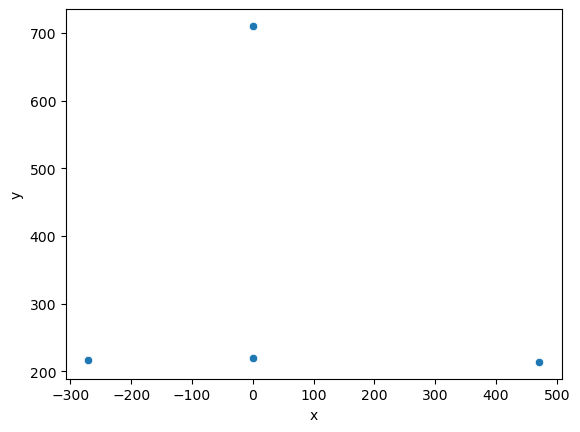

In [103]:
import pandas as pd

# img = np.zeros((0,300))
# draw_line_segment(y.pos[0],y.pos[1],img)
sns.scatterplot(pd.DataFrame(np.array(list(y.pos.values())), columns = ['x', 'y']), x= 'x', y = 'y')

In [224]:
lung = Lung(depth = 2, partial_fractal_depth=1)
for u,v ,length in lung.tree.edges(data = 'length'):
    #add noise to length
    lung.tree[u][v]['length'] = length +np.random.random() *length
lung,pos = set_positions(lung.tree, step = 90, inital_angle=145)
pos = nx.get_node_attributes(lung, 'pos')
pos = {k:np.concatenate((v,np.array([0]))) for k,v in pos.items()}
nx.set_node_attributes(lung, pos, 'pos')

lungc = lung.copy()

augment_tree(lungc)
add_rotation_to_tree(lungc)
#rotate whole tree
# augment_tree(lungc)
#create image from graph
pad_size = 40

# skel_image,branch_point_image,edge_point_image = graph_to_image(lungc, pad_size = pad_size)
#add a small boarder, so dilituion doesnt fail at the boundaries
# skel_image_dils, skel_image, branch_point_image, edge_point_image = sg.graph_to_diluted_image(lungc, pad_size = pad_size)
# skel_image = graph_to_image(lungc, pad_size = pad_size)
skel_image_dils, skel_image, branch_point_image, edge_point_image = graph_to_diluted_image(lungc, 
                                                                                           pad_size = pad_size, 
                                                                                           elipse_dilute = True,
                                                                                           include_edge_points = True)

{2: array([ 53.06131691, 219.31277151]), 3: array([-50.8108468 , 219.34191868]), 0: array([  0.        , 298.68749059]), 1: array([  0, 220])}
[0.18636567 0.31060944 0.00887456]
dilating level 0
image bounds  [191 628 114]
point max [109.78322859 588.93720061  79.86937404]
dilating level 1
image bounds  [191 628 114]
point max [153.225635   514.02281131  74.04208293]
image bounds  [191 628 114]
point max [ 99.6302977  517.27706548  64.73422225]
dilute tips


In [225]:
# viewer= napari.Viewer()
viewer.add_image(skel_image_dils)
viewer.add_image(skel_image)

<Image layer 'skel_image [2]' at 0x7f91ea240df0>

In [218]:
from importlib import reload
reload(sg)
#load tree graph
# with open("/home/mmederacke/lung_fractal/ml/generate_lung_skeletons/run/Lung_graph2d_2.pickle",'rb') as f:
#     lung = pickle.load(f)
# print([len([n for n,d in lung.degree() if d == 1])])


lung,pos = set_positions(lung, step = 40)
pos = nx.get_node_attributes(lung, 'pos')
pos = {k:np.concatenate((v,np.array([0]))) for k,v in pos.items()}




nx.set_node_attributes(lung, pos, 'pos')
# for i in range(1,200):
lungc = lung.copy()
#rotate subtrees
augment_tree(lungc)
add_rotation_to_tree(lungc)
#rotate whole tree
# augment_tree(lungc)
#create image from graph
pad_size = 40

# skel_image,branch_point_image,edge_point_image = graph_to_image(lungc, pad_size = pad_size)
#add a small boarder, so dilituion doesnt fail at the boundaries
# skel_image_dils, skel_image, branch_point_image, edge_point_image = sg.graph_to_diluted_image(lungc, pad_size = pad_size)
# skel_image = graph_to_image(lungc, pad_size = pad_size)
skel_image_dils, skel_image, branch_point_image, edge_point_image = graph_to_diluted_image(lungc, 
                                                                                           pad_size = pad_size, 
                                                                                           elipse_dilute = True,
                                                                                           include_edge_points = True)



{2: array([ 30.88548647, 198.69472229]), 3: array([-27.29756833, 201.16972273]), 0: array([  0.        , 273.85293819]), 1: array([  0, 220])}
[-0.43485322 -0.50584966  0.16861655]
dilating level 0
image bounds  [147 586 116]
point max [ 82.92383065 546.22479179  75.14034745]
dilating level 1
image bounds  [147 586 116]
point max [107.89971518 496.29986421  76.81103238]
image bounds  [147 586 116]
point max [ 74.3299805  496.23167985  76.63219927]
dilute tips


In [219]:
# viewer.add_image(skel_image_dils)
viewer.add_image(skel_image_dils)
viewer.add_image(skel_image)

<Image layer 'skel_image [1]' at 0x7f91ea0bba00>

In [94]:


#resacle image to be squared. Otherwise mesh voxelation shifts image.
rescale_factor = np.array([skel_image.shape[1]/(skel_image.shape[0]), 
                        skel_image.shape[1]/skel_image.shape[1], 
                        skel_image.shape[1]/skel_image.shape[2]])

#dilute tree image to get a volume
# rescaled_shape= [np.min(skel_image.shape[1])]*3
skel_image = skimage.transform.rescale(skel_image,rescale_factor, order=1)
skel_image_dils = skimage.transform.rescale(skel_image_dils,rescale_factor, order=0)

skeleton_mask = np.zeros_like(skel_image_dils, dtype=bool)
skeleton_mask[skel_image_dils > 0] = 1
#get branch and edge points

#add noise to surface to get proper bumps and a more continuouse surface
skel_mesh_vox = add_noise_to_image_surface(skeleton_mask)

<trimesh.Trimesh(vertices.shape=(7208, 3), faces.shape=(14563, 3))>


sh: -c: line 0: unexpected EOF while looking for matching ``'
sh: -c: line 1: syntax error: unexpected end of file


In [95]:
viewer.add_image(skel_image, blending='additive')
viewer.add_image(skel_image_dils, blending='additive', opacity=0.6)

viewer.add_image(skel_mesh_vox, blending='additive', opacity=0.8)



<Image layer 'skel_mesh_vox [2]' at 0x7f91eaa9a250>

In [88]:
skeleton_gaussian_size = 0
skeleton_dilation_size = 0
print(skeleton_dilation_size)

skeletonization_target =make_skeleton_blur_image(skeleton_image= skel_image,
                                                 gaussian_size = skeleton_gaussian_size,
                                                 dilation_size = skeleton_dilation_size)

normalized_vector_image = make_segmentation_distance_image_norm_non_vector(skel_mesh_vox)

0


In [89]:
viewer.add_image(normalized_vector_image, blending='additive', opacity=0.8)
viewer.add_image(skeletonization_target, blending='additive', opacity=0.8)


<Image layer 'skeletonization_target' at 0x7f91eabc33a0>

In [ ]:
skel_mesh_vox_small  = skimage.transform.rescale(skel_mesh_vox, 0.25, order=0)
skel_image_small = skimage.transform.rescale(skel_image, 0.25, order=0)
viewer.add_image(skel_mesh_vox_small)
viewer.add_image(skel_image_small)


skeletonization_target =make_skeleton_blur_image(skeleton_image= skel_image_small,
                                                 gaussian_size = skeleton_gaussian_size,
                                                 dilation_size = skeleton_dilation_size)

normalized_vector_image = make_segmentation_distance_image_norm_non_vector(skel_mesh_vox_small)

viewer.add_image(normalized_vector_image, blending='additive', opacity=0.8)
viewer.add_image(skeletonization_target, blending='additive', opacity=0.8)


In [15]:
viewer.add_image(segmentation_distance)
viewer.add_image(skeletonization_target, blending='additive')

<Image layer 'skeletonization_target' at 0x7f40aa92e820>

In [217]:
# viewer = napari.Viewer()
with h5py.File('/home/mmederacke/lung_fractal/ml/synthetic_trainings_data/simulated_trees_distance_only/lung_skeleton_rotated_1.h5','r') as f:
    print(f.keys())
    normalized_vector_image = f['normalized_vector_background_image'][:]
    segmentation_image = f['segmentation_image'][:]
    skeletonization_target = f['skeletonization_target'][:]
    skeleton_image = f['skeleton_image'][:]    
    segmentation_label_image = f['segmentation_label_image'][:]

<KeysViewHDF5 ['normalized_vector_background_image', 'segmentation_image', 'segmentation_label_image', 'skeleton_image', 'skeletonization_target']>


In [218]:
viewer.add_image(normalized_vector_image, blending='additive', opacity=0.8)
viewer.add_image(segmentation_image, blending='additive', opacity=0.8)
viewer.add_image(skeletonization_target, blending='additive', opacity=0.8)
viewer.add_image(skeleton_image, blending='additive', opacity=0.8)
viewer.add_labels(segmentation_label_image)

<Labels layer 'segmentation_label_image [1]' at 0x7f516de29850>

In [88]:
np.sum(skeletonization_target >0.3)

52660

In [106]:
# segmentation_label_image[skel_mesh_vox != 0] = 1
# segmentation_label_image[skeletonization_target > 0.3] =2
# segmentation_label_image = segmentation_label_image.astype(np.uint8)
np.sum(segmentation_label_image ==2)

48869

In [105]:
segmentation_label_image = np.zeros(skel_mesh_vox.shape)
segmentation_label_image[skel_mesh_vox != 0] = 1
segmentation_label_image[skeletonization_target > 0.3] = 2
segmentation_label_image[skel_mesh_vox == 0] = 0
segmentation_label_image = segmentation_label_image.astype(np.uint8)

In [107]:
viewer.add_labels(segmentation_label_image, blending='additive', opacity=0.8)

<Labels layer 'segmentation_label_image [2]' at 0x7f0253e01940>

In [184]:
with h5py.File('/home/mmederacke/lung_fractal/ml/synthetic_trainings_data/simulated_t/simulated_t40.h5', 'r') as f:
    raw = f['raw'][:]
    label = f['label'][:]

In [11]:
viewer = napari.Viewer()

In [185]:
viewer.add_image(raw)
viewer.add_labels(label)

<Labels layer 'label [1]' at 0x7f91dafda0d0>